Variables to modify...

In [1]:
score_df = pd.DataFrame()

### Load Vectors

Pico vectors...

In [24]:
pico_elements = ['populations', 'interventions', 'outcomes']

nb_val = 1126
H = np.empty(shape=[nb_val, 0])
for pico_element in pico_elements:
    H_pico = pickle.load(open('../../visualization/val_vectors/{}.p'.format(pico_element)))
    H = np.concatenate([H, H_pico], axis=1)

Doc2vec vectors...

In [19]:
H = pickle.load(open('../../visualization/val_vectors/doc2vec.p'))

nb_val = len(H)

### Infer Validation Documents

In [5]:
from batch_generators import study_target_generator

df = pd.read_csv('../../preprocess/pico_nonoverlapping_tokenized.csv')

from sklearn.cross_validation import train_test_split

cdnos = np.array(df.groupby('cdno').size().sort_values(ascending=False).index)
nb_cdno = len(cdnos)

_, val_cdno_idxs = train_test_split(np.arange(nb_cdno), train_size=.97, random_state=1337)
val_cdno_idxs = np.sort(val_cdno_idxs)
val_cdnos = set(cdnos[val_cdno_idxs])
val_study_idxs = np.array(df[df.cdno.isin(val_cdnos)].index)

cdnos = df.cdno.ix[val_study_idxs].reset_index(drop=True)

### Create Relevance Matrix

In [6]:
cdno2idxs = {name: group.index.tolist() for name, group in cdnos.groupby(cdnos)}

R = np.zeros([nb_val, nb_val])
for i, cdno in enumerate(cdnos):
    R[i, cdno2idxs[cdno]] = 1
    
R[np.arange(nb_val), np.arange(nb_val)] = 0 # documents are not relevant to themselves0

R

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.]])

### Create Simliarity Matrix

In [25]:
S = np.dot(H, H.T)
S[np.arange(nb_val), np.arange(nb_val)] = -np.inf # hackily remove each vector's similarity with itself
S *= -1 # sort by ascending

sorted_idxs = S.argsort()

Shift relevance matrix to reflect ordering of highest scores...

In [26]:
P = np.zeros_like(R)

for i, idx_row in enumerate(sorted_idxs):
    P[i] = R[[i]*nb_val, list(idx_row)]

### PICO Precision

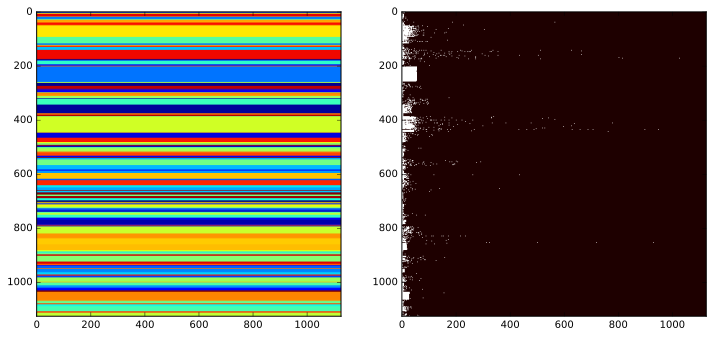

In [27]:
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=[12, 12])

from matplotlib import cm

axes2.imshow(P, interpolation='nearest', cmap=cm.pink)

a = np.zeros_like(P)
a[:] = np.array(cdnos.astype('category').cat.codes)[:, np.newaxis]
axes1.imshow(a)

plt.show()

In [28]:
k = 10

precisions = P[:, :k].sum(axis=1) / k

np.mean(precisions)

0.66021314387211361

### Doc2Vec Precision

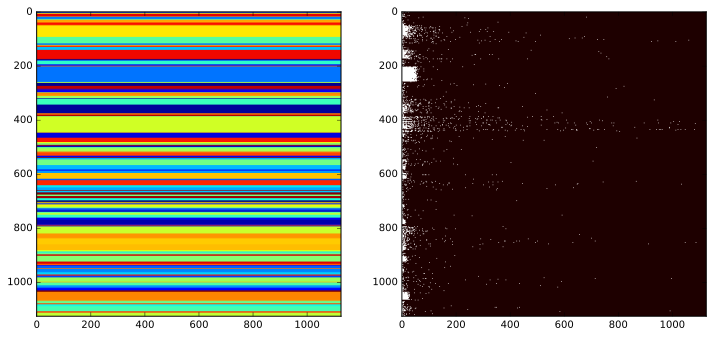

In [22]:
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=[12, 12])

from matplotlib import cm

axes2.imshow(P, interpolation='nearest', cmap=cm.pink)

a = np.zeros_like(P)
a[:] = np.array(cdnos.astype('category').cat.codes)[:, np.newaxis]
axes1.imshow(a)

plt.show()

In [23]:
k = 10

precisions = P[:, :k].sum(axis=1) / k

np.mean(precisions)

0.55657193605683841

### Normalize Vectors

In [78]:
source_norms = np.apply_along_axis(np.linalg.norm, axis=1, arr=H_source)
target_norms = np.apply_along_axis(np.linalg.norm, axis=1, arr=H_target)

H_source /= source_norms[:, np.newaxis]
H_target /= target_norms[:, np.newaxis]

### Compute Scores

In [79]:
score = np.sum(H_source * H_target, axis=1)

same_study_mean = score[:nb_val].mean()
different_study_mean = score[nb_val:].mean()

same_study_mean / different_study_mean

20.349203

In [80]:
same_study_mean

0.21487758

In [81]:
different_study_mean

0.010559508

In [82]:
dff = pd.DataFrame({'score': same_study_mean / different_study_mean,
                    'same_study_mean': same_study_mean,
                    'different_study_mean': different_study_mean},
                   index=[vector_type])

score_df = score_df.append(dff)

score_df

,different_study_mean,same_study_mean,score
populations,0.186007,0.602183,3.237427
interventions,0.304939,0.632681,2.074781
outcomes,0.248564,0.610681,2.456840
doc2vec,0.010560,0.214878,20.349203


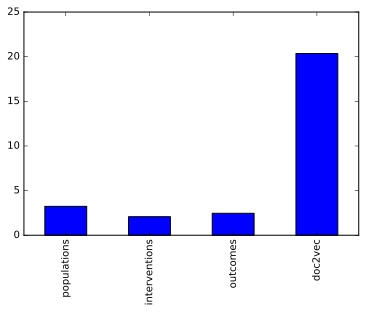

In [86]:
score_df.score.plot(kind='bar')

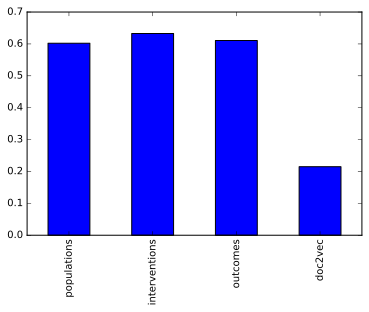

In [84]:
score_df.same_study_mean.plot(kind='bar')

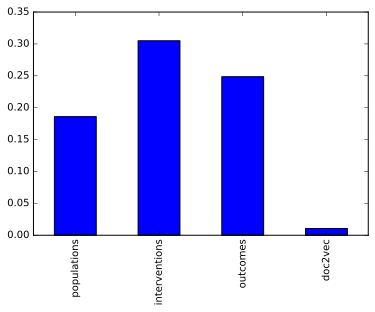

In [85]:
score_df.different_study_mean.plot(kind='bar')